In [1]:
from __future__ import absolute_import, print_function, division

In [2]:
import time

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [6]:
n_inputs = 3
n_neurons = 5

### Raw RNN

In [7]:
graph = tf.Graph()

with graph.as_default():
    x0 = tf.placeholder(tf.float32, [None, n_inputs])
    x1 = tf.placeholder(tf.float32, [None, n_inputs])
    
    Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
    Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
    b = tf.Variable(tf.zeros(shape=[1, n_neurons], dtype=tf.float32))
    
    Y0 = tf.tanh(tf.matmul(x0, Wx) + b)
    Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(x1, Wx) +b)
    
    init = tf.global_variables_initializer()

In [8]:
x0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t0
x1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t1

In [9]:
def run_session(graph):
    with tf.Session(graph=graph) as sess, tf.device("/cpu"):
        init.run()
        feed_dict = {x0:x0_batch, x1:x1_batch}
        Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict)
    return Y0_val, Y1_val

In [10]:
Y0_val, Y1_val = run_session(graph)
Y0_val.shape, Y1_val.shape

((4, 5), (4, 5))

In [11]:
print(Y0_val)

[[ 0.9573673   0.6773486   0.97555345  0.9502508   0.9909814 ]
 [ 0.99999994  0.9239658   0.99999994  0.9785577   0.90531147]
 [ 1.          0.9838924   1.          0.99083394  0.29429385]
 [ 0.98430026  0.9993857   0.8451181  -0.15980001 -1.        ]]


In [12]:
print(Y1_val)

[[ 1.         -0.9990067   1.         -0.7536234  -0.99811506]
 [-0.9969545  -0.9999865  -0.10779818 -0.36677852  0.99590737]
 [ 0.9999999  -0.9999139   1.         -0.9376918  -0.9882047 ]
 [ 0.9999624  -0.9996615   0.9999995  -0.80706525 -0.9880308 ]]


### TensorFlow RNN API: BasicRNNCell

In [13]:
graph = tf.Graph()

with graph.as_default():
    x0 = tf.placeholder(tf.float32, [None, n_inputs])
    x1 = tf.placeholder(tf.float32, [None, n_inputs])
    
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
    output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [x0, x1], dtype=tf.float32)
    
    Y0, Y1 = output_seqs
    
    init = tf.global_variables_initializer()

In [14]:
Y0_val, Y1_val = run_session(graph)
Y0_val.shape, Y1_val.shape

((4, 5), (4, 5))

In [15]:
print(Y0_val)

[[ 0.8974375   0.8661767  -0.4359543  -0.8871651   0.55911165]
 [ 0.99995315  0.99422175 -0.96411574 -0.99948204  0.02265221]
 [ 1.          0.9997659  -0.9983019  -0.99999774 -0.5271772 ]
 [ 0.99948967 -0.99369735 -0.87139356  0.14518003 -0.82000744]]


In [16]:
print(Y1_val)

[[ 1.          0.9987629  -0.9993588  -0.9999992  -0.9939048 ]
 [ 0.04302417  0.02070792  0.334572   -0.24871786 -0.4146878 ]
 [ 0.99999577  0.9453452  -0.9782288  -0.99933016 -0.984193  ]
 [ 0.99756044 -0.40606126 -0.0749407  -0.9383426  -0.6825826 ]]


### Unstacking timesteps + stacking output sequence

In [17]:
graph = tf.Graph()
n_steps = 2
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
    X_seqs = tf.unstack(tf.transpose(X, [1, 0, 2]))
    
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
    output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
    
    outputs = tf.stack(tf.transpose(output_seqs, perm=[1, 0, 2]))

In [18]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

In [19]:
print(X_batch.shape)
a,b,c = X_batch.shape
print("{0} instances, {1} time steps, input size of {2}".format(a,b,c))

(4, 2, 3)
4 instances, 2 time steps, input size of 3


In [20]:
def run_session(graph, sequence_length=None):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        feed_dict = {X:X_batch}
        if sequence_length is not None:
            feed_dict.update({seq_length:sequence_length})
        output_vals, states_vals = sess.run([outputs, states],feed_dict)
        
    a,b,c = np.array(output_vals).shape
    print((a,b,c))
    print("{0} instances, {1} time steps, input size of {2}".format(a,b,c))
    ds = [[str(timestep) for timestep in instance] for instance in output_vals]
    
    return pd.DataFrame(ds, columns=["t0","t1"], index=['x%d'%i for i in range(len(output_vals))])

In [21]:
run_session(graph)

(4, 2, 5)
4 instances, 2 time steps, input size of 5


,t0,t1
x0,[-0.04009885 -0.8097802 0.6762576 -0.916290...,[-0.9999956 -0.9999998 0.9411002 -0.9998157 ...
x1,[-0.9721545 -0.9998215 0.95019644 -0.998169...,[-0.19014953 0.88836277 -0.70430195 -0.463070...
x2,[-0.99956805 -0.9999998 0.99326915 -0.999961...,[-0.99965686 -0.9997536 0.30035114 -0.992794...
x3,[-0.9999673 -0.99983466 0.89278525 0.989620...,[-0.9947011 -0.988457 -0.25621665 -0.281493...


### Dynamic unrolling through time

In [22]:
graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
    ## NO NEED TO UNSTACK X :)
    
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
    
    ## NO NEED TO STACK outputs

In [23]:
run_session(graph)

(4, 2, 5)
4 instances, 2 time steps, input size of 5


,t0,t1
x0,[-0.1801341 0.48659524 -0.7052162 -0.736500...,[-0.23058982 0.93670666 -0.9993907 -0.999999...
x1,[-0.3121507 0.82479316 -0.98856443 -0.999575...,[ 0.12767349 0.6412871 -0.24981414 0.909634...
x2,[-0.43312082 0.9480008 -0.99961746 -0.999999...,[ 0.00689895 0.9285619 -0.99554133 -0.999386...
x3,[ 0.90694964 0.9823909 -0.9770128 -0.999936...,[ 0.5756405 0.8181405 -0.6825235 -0.8763856 -...


### Handling variable length input sequence

In [24]:
sequence_length_batch = np.array([2,1,2,2])

In [25]:
graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
    seq_length = tf.placeholder(tf.int32, shape=[None])
    
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, sequence_length=seq_length, dtype=tf.float32)

In [26]:
run_session(graph, sequence_length_batch)

(4, 2, 5)
4 instances, 2 time steps, input size of 5


,t0,t1
x0,[ 0.12449772 -0.35615012 0.49179465 -0.752073...,[-0.35985196 -0.9967861 -0.9190389 -0.981807...
x1,[-0.01571311 -0.93581253 0.33472428 -0.966152...,[0. 0. 0. 0. 0.]
x2,[-0.1553087 -0.99537915 0.15655549 -0.995820...,[ 0.10091326 -0.9885842 -0.88180786 -0.786118...
x3,[-0.76619244 0.31452423 -0.9994086 0.073607...,[ 0.10694895 -0.9620907 -0.30339572 0.662319...


### Predicting time series data
<img src="https://images-na.ssl-images-amazon.com/images/I/51%2B1JJxFM3L._UX385_.jpg">

In [27]:
n_steps = 20
n_inputs = 1
n_outputs = 1
n_neurons = 100

In [28]:
batch_size=500
t_min = 0
t_max = 30
resolution = 0.1

In [29]:
time_series= lambda t: t*np.sin(t)/3 + 2*np.sin(5*t)
def generate_batch(batch_size=500, t_min = 0, t_max = 30, resolution = 0.1, n_steps=20):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps+1) * resolution
    ys = time_series(Ts)
    return ys[:,:-1].reshape(-1,n_steps, n_inputs), ys[:,1:].reshape(-1,n_steps, n_outputs)

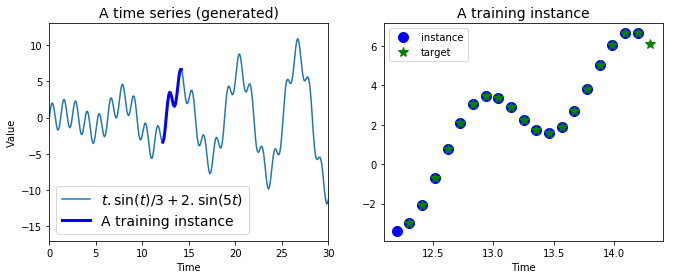

In [30]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "g*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


plt.show()

### Using `OutputProjectionWrapper`

In [31]:
graph = tf.Graph()

with graph.as_default():
    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
    
    cell = tf.contrib.rnn.OutputProjectionWrapper(
        tf.contrib.rnn.BasicRNNCell(n_neurons, activation=tf.nn.relu),n_outputs)
    outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    
    learning_rate = 0.001
    
    loss = tf.reduce_mean(tf.losses.mean_squared_error(outputs, y))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    _saver = tf.train.Saver()
    
    init = tf.global_variables_initializer()

In [32]:
def run_session(graph, save_name='./sess', n_steps=20):
    
    t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))
    t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)
    
    start = time.time()
    with tf.Session(graph=graph) as sess, tf.device("/gpu"):
        init.run()
        for i in range(1001):
            batch_x,batch_y = generate_batch(1000, n_steps=n_steps)
            _, loss_value = sess.run([optimizer, loss], feed_dict={X:batch_x, y:batch_y})
            if i%100 == 0:
                print("{0}\tMSE: {1}".format(i, loss_value))
        y_pred, y_states = sess.run(
            [outputs, states], feed_dict={X:time_series(t_instance[:-1].reshape(-1, n_steps, n_inputs))})
        _saver.save(sess, save_name)
    print("Excution time: ",time.time()-start)
    plt.figure(figsize=(12,7))
    plt.title("A training instance", fontsize=14)
    plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="target")
    plt.plot(t_instance[1:], time_series(t_instance[1:]), "g*", markersize=10, label="target")
    plt.plot(t_instance[1:], y_pred.reshape(-1), "r.", markersize=10, label="prediction")
    plt.legend(loc="upper left")
    plt.xlabel("Time")
    return _saver

0	MSE: 18.500988006591797
100	MSE: 0.5795389413833618
200	MSE: 0.27513453364372253
300	MSE: 0.12749402225017548
400	MSE: 0.0725756287574768
500	MSE: 0.05657791718840599
600	MSE: 0.05189034342765808
700	MSE: 0.05271995812654495
800	MSE: 0.047196388244628906
900	MSE: 0.047588150948286057
1000	MSE: 0.04786102473735809
Excution time:  13.559691667556763


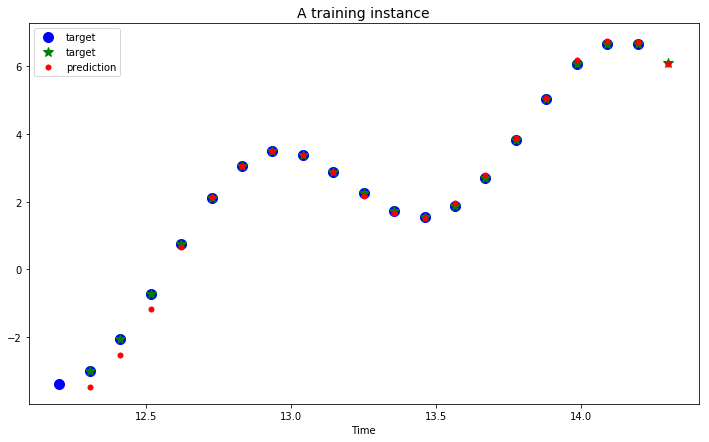

In [33]:
run_session(graph)

### Using un/stacking input/output without  `OutputProjectionWrapper`

In [34]:
n_steps = 50

In [35]:
graph = tf.Graph()

with graph.as_default():
    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
    
    cell = tf.contrib.rnn.BasicRNNCell(n_neurons, activation=tf.nn.relu)

    outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    
    stacked_rnn_outputs = tf.reshape(outputs, (-1, n_neurons))  # output vectors
    stacked_outputs = tf.contrib.layers.fully_connected(
        stacked_rnn_outputs, n_outputs, activation_fn=None) # output scalars
    outputs = tf.reshape(stacked_outputs, (-1, n_steps, n_outputs))
    
    learning_rate = 0.001
    
    loss = tf.reduce_mean(tf.losses.mean_squared_error(outputs, y))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    _saver = tf.train.Saver()
    
    init = tf.global_variables_initializer()

0	MSE: 14.541037559509277
100	MSE: 0.23668180406093597
200	MSE: 0.13121050596237183
300	MSE: 0.06808270514011383
400	MSE: 0.041545186191797256
500	MSE: 0.028110405430197716
600	MSE: 0.02284049801528454
700	MSE: 0.02112269029021263
800	MSE: 0.020565293729305267
900	MSE: 0.019526777788996696
1000	MSE: 0.018675513565540314
Excution time:  24.4758939743042


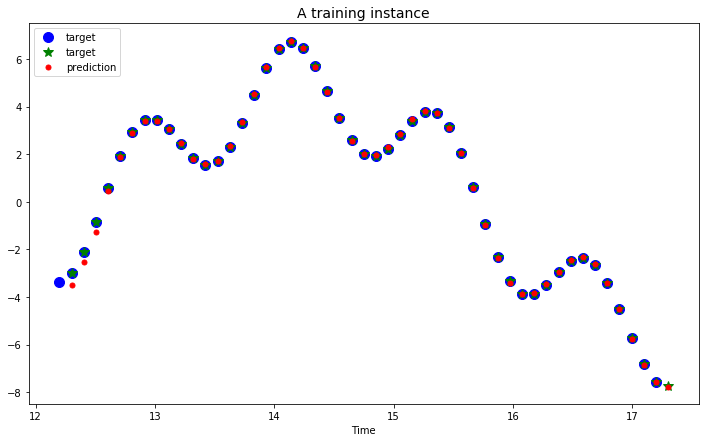

In [36]:
saver = run_session(graph, n_steps=n_steps)

## Generative RNNs

In [40]:
with tf.Session(graph=graph) as sess:
    saver.restore(sess, './sess')
    batch_x,y_batch = generate_batch(1, n_steps=n_steps)
    sequence = list(batch_x.reshape(-1))
    for i in range(300):
        x_batch = np.array(sequence[-n_steps:])
        y_pred = sess.run(outputs, feed_dict={X: x_batch.reshape(1, n_steps, n_inputs)})
        # Here is the generative part :)
        assert y_pred.reshape(-1)[-1]==y_pred[0,-1,0]
        sequence.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./sess


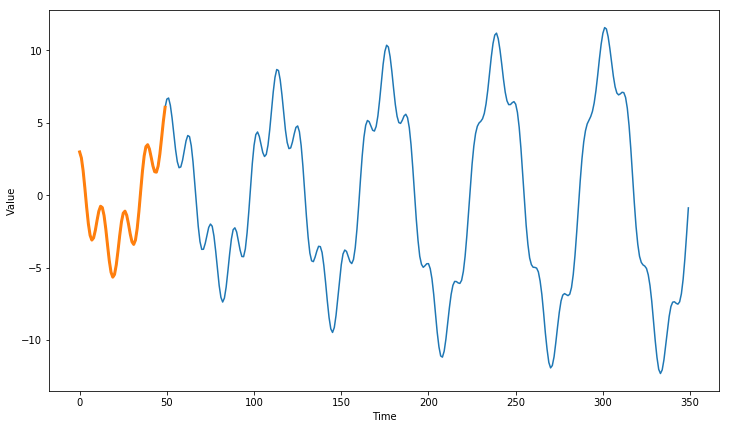

In [41]:
plt.figure(figsize=(12,7))
plt.plot(np.arange((len(sequence))), sequence)
plt.plot(sequence[:n_steps],linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()